# Programming Assignment 3
* CSCI-4930/5930 ML Spring 2019
* Author: Shreya Dubey 

# Naive Bayes Classifier

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
sns.set()
import sklearn
from sklearn import metrics
from sklearn.model_selection import train_test_split
import warnings
import math
warnings.filterwarnings("ignore",category=FutureWarning)
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
# Reading the data from csv file
X = pd.read_csv("Set-A.X.csv")
Y = pd.read_csv("Set-A.y.csv")

In [3]:
#Reading the B data set csv file
X_B = pd.read_csv("Set-B.X.csv")
Y_B = pd.read_csv("Set-B.y.csv")

I have replaced the missing values by the most frequent value

In [4]:
# Handling the missing values
m = X['domain1']
most_frequent = pd.get_dummies(m).sum().sort_values(ascending=False).index[0] 
def replace_most_frequent(x):
    if pd.isnull(x):
        return most_frequent
    else:
        return x
new_m = m.map(replace_most_frequent)
X['domain1'] = new_m
#print("new Value = ",X.iloc[70382]['domain1'])

# Handling the missing values in B data set
m = X_B['state1']
most_frequent = pd.get_dummies(m).sum().sort_values(ascending=False).index[0] 
def replace_most_frequent(x):
    if pd.isnull(x):
        return most_frequent
    else:
        return x
new_m = m.map(replace_most_frequent)
X_B['state1'] = new_m

In [5]:
# Changing the categorical value to numerical value
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

df_train_dum = X['state1']
df_train_dum_encoded = encoder.fit_transform(df_train_dum)

df_train_dum1 = X['domain1']
df_train_dum1_encoded = encoder.fit_transform(df_train_dum1)

X['state1'] = df_train_dum_encoded
X['domain1'] = df_train_dum1_encoded

df_train_B_dum = X_B['state1']
df_train_B_dum_encoded = encoder.fit_transform(df_train_B_dum)

df_train_B_dum1 = X_B['custAttr2']
df_train_B_dum1_encoded = encoder.fit_transform(df_train_B_dum1)

X_B['state1'] = df_train_B_dum_encoded
X_B['custAttr2'] = df_train_B_dum1_encoded

In [6]:
# Changing to numpy
X = X.values
X_new = X[0:94681,:]

X_B = X_B.values
X_B_new = X_B[0:99999,:]

In [7]:
# Joining the X and Y into one data set
X_new = np.append(X_new,Y,axis=1)

X_B_new = np.append(X_B_new,Y_B,axis=1)

Task 2.5 Creating a smaller database which is less skewed by taking all the samples that are positive and taking less samples that are negative so that the positive samples are not a small percentage of the data set.

In [8]:
# Creating less skewed data set
m = 0
n = 0
X_train_whole = np.empty((20940,20))
X_not_fraud = np.empty((92587,20))
for a in X_new:
    if(a[-1]==1):
        X_train_whole[m,:] = a
        m = m+1
    else:
        X_not_fraud[n,:] = a
        n = n+1

for j in range (18846):
    X_train_whole[m+j,:] = X_not_fraud[j,:]
    
# Creating a less skewed data set for B data set
m1 = 0
n1 = 0
X_train_B_whole = np.empty((26540,20))
X_not_B_fraud = np.empty((97345,20))
for a in X_B_new:
    if(a[-1]==1):
        X_train_B_whole[m1,:] = a
        m1 = m1+1
    else:
        X_not_B_fraud[n1,:] = a
        n1 = n1+1

for j in range (23886):
    X_train_B_whole[m1+j,:] = X_not_B_fraud[j,:]

Using the appropriate command here between using the whole data set and using a smaller data set which is less skewed

In [9]:
# Splitting data into training and testing data
#train_set, test_set = train_test_split(X_new, test_size=0.20)
train_set, test_set = train_test_split(X_train_whole, test_size=0.20 )

#train_set_B, test_set_B = train_test_split(X_B_new, test_size=0.20)
train_set_B, test_set_B = train_test_split(X_train_B_whole, test_size=0.20 )

In [10]:
#seperating by class
def separateByClass(dataset):
    separated = {}
    for i in range(len(dataset)):
        vector = dataset[i]
        if (vector[-1] not in separated):
            separated[vector[-1]] = []
        separated[vector[-1]].append(vector)
    return separated

In [11]:
# function for mean and standard deviation
def mean(numbers):
    return sum(numbers)/float(len(numbers))
 
def stdev(numbers):
    avg = mean(numbers)
    variance = sum([pow(x-avg,2) for x in numbers])/float(len(numbers)-1)
    return math.sqrt(variance)

In [12]:
#function to generate summary
def summarize(dataset):
    summaries = [(mean(attribute), stdev(attribute)) for attribute in zip(*dataset)]
    del summaries[-1]
    return summaries

In [13]:
# summary after seperating by class
def summarizeByClass(dataset):
    separated = separateByClass(dataset)
    summaries = {}
    for classValue, instances in separated.items():
        summaries[classValue] = summarize(instances)
    return summaries

In [14]:
# Function to calculate probability of one variable
def calculateProbability(x, mean, stdev):
    exponent = math.exp(-(math.pow(x-mean,2)/(2*math.pow(stdev,2))))
    return (1 / (math.sqrt(2*math.pi) * stdev)) * exponent

In [15]:
# calculating probability by class
def calculateClassProbabilities(summaries, inputVector,probability1):
    probabilities = {}
    for classValue, classSummaries in summaries.items():
        probabilities[classValue] = 1
        for i in range(len(classSummaries)):
            mean, stdev = classSummaries[i]
            x = inputVector[i]
            probabilities[classValue] *= calculateProbability(x, mean, stdev)
    probabilities[0.0] *=probability1[0]
    probabilities[1.0] *=probability1[1]
    return probabilities

In [16]:
# Function to predict best label
def predict(summaries, inputVector, probabilities1):
    probabilities = calculateClassProbabilities(summaries, inputVector, probabilities1)
    bestLabel, bestProb = None, -1
    for classValue, probability in probabilities.items():
        if(classValue==1.0):
            prob_score=probability
        if bestLabel is None or probability > bestProb:
            bestProb = probability
            bestLabel = classValue
    return bestLabel, prob_score

In [27]:
# Function to get prediction for data set
def getPredictions(summaries, testSet,probabilities):
    predictions = []
    predict_score = []
    for i in range(len(testSet)):
        result,prob_score = predict(summaries, testSet[i],probabilities[i])
        predictions.append(result)
        predict_score.append(prob_score)
    return predictions,predict_score

In [28]:
# Using Laplacian smoothing
def calculateProb(n1,n0,s):
    probFor1 = (n1+1)/(n1+n0+s)
    probFor0 = (n0+1)/(n1+n0+s)
    return probFor0, probFor1

In [29]:
def getN1andN0(value,index,dataset):
    n1 = 0
    n0 = 0
    variable = dataset[:,index]
    classVector = dataset[:,-1]
    for i in range (len(variable)):
        if(variable[i]==value):
            if(classVector[i]==1):
                n1 =n1+1
            else:
                n0 = n0+1
    return n1, n0

In [30]:
def getS(dataset):
    numOfValues = np.empty(dataset.shape[1]-1)
    for i in range (dataset.shape[1]-1):
        numOfValues[i] = len(np.unique(dataset[:,i]))
    return numOfValues

In [31]:
def calculateProbDiscrete(dataset):
    numOfValues = getS(dataset)
    probability = np.empty((dataset.shape[0],2))
    for row in range (dataset.shape[0]):
        probability[row,0] = 1
        probability[row,1] = 1
        for var in range (dataset.shape[1]-1):
            value = dataset[row,var]
            index = var
            n1,n0 = getN1andN0(value,index,dataset)
            prob0,prob1 = calculateProb(n1,n0,numOfValues[var])
        probability[row,0] *=prob0
        probability[row,1] *=prob1
    return probability

In [32]:
def getCost(tp,tn,fp,fn):
    Cost2 = (tp*(-1))+(tn*(0))+(fp*100)+(fn*(1))
    Cost1 = (tp*(-1))+(tn*(0))+(fp*1)+(fn*(100))
    return Cost1,Cost2

In [33]:
# Function to get results
def getResult(Y_test,learned_Y,y_score):
    confusion_matrix = metrics.confusion_matrix(Y_test,learned_Y)
    tn, fp, fn, tp = metrics.confusion_matrix(Y_test,learned_Y).ravel()
    accuracy = metrics.accuracy_score(Y_test,learned_Y)
    precision = metrics.precision_score(Y_test,learned_Y) 
    recall = metrics.recall_score(Y_test,learned_Y)
    fscore = metrics.f1_score(Y_test,learned_Y)
    fpr, tpr, thresholds = metrics.roc_curve(Y_test,y_score) 
    auc = metrics.roc_auc_score(Y_test,y_score)
    
    print("Naive Bayes Classifier")
    print("confusion matrix = ",confusion_matrix)
    print("tp = ",tp,"fp = ",fp,"fn = ",fn,"tn = ",tn)
    print("accuracy score  = ",accuracy)
    print("precision = ",precision)
    print("recall = ",recall)
    print("F1-score = ",fscore)
    print("auc = ",auc)
    cost1,cost2 = getCost(tp,tn,fp,fn)
    print("Cost for less false negative = ",cost1)
    print("Cost for less false positive = ",cost2)
    
    plt.plot(fpr,tpr)
    plt.plot(fpr,fpr,linestyle = 'dashed', color = 'olive')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()

In [34]:
# seperating Y from train and test data
Y_train = train_set[:,-1]
Y_test = test_set[:,-1]

Y_train_B = train_set_B[:,-1]
Y_test_B = test_set_B[:,-1]

In [35]:
# Preparing data by seperating continuos and discrete variables
def prepareData(train_set):
    continuos_var = np.empty((train_set.shape[0],7))
    continuos_var[:,0] = train_set[:,0]
    continuos_var[:,1] = train_set[:,3]
    continuos_var[:,2] = train_set[:,5]
    continuos_var[:,3] = train_set[:,9]
    continuos_var[:,4] = train_set[:,10]
    continuos_var[:,5] = train_set[:,11]
    continuos_var[:,6] = train_set[:,-1]
    discrete_var = train_set
    discrete_var = np.delete(discrete_var,0,1)
    discrete_var = np.delete(discrete_var,2,1)
    discrete_var = np.delete(discrete_var,3,1)
    discrete_var = np.delete(discrete_var,6,1)
    discrete_var = np.delete(discrete_var,6,1)
    discrete_var = np.delete(discrete_var,6,1)
    return continuos_var,discrete_var

Task 2.1 5 fold cross validation

Naive Bayes Classifier
confusion matrix =  [[12026    33]
 [ 1294    48]]
tp =  48 fp =  33 fn =  1294 tn =  12026
accuracy score  =  0.9009775389896276
precision =  0.5925925925925926
recall =  0.03576751117734724
F1-score =  0.067463106113844
auc =  0.5488746709700654
Cost for less false negative =  129385
Cost for less false positive =  4546


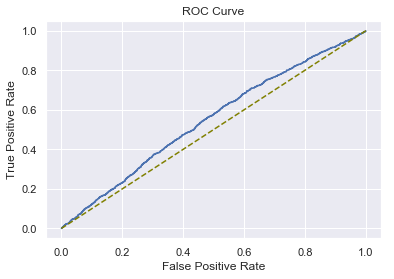

Naive Bayes Classifier
confusion matrix =  [[3016    6]
 [ 315   14]]
tp =  14 fp =  6 fn =  315 tn =  3016
accuracy score  =  0.9042076991942704
precision =  0.7
recall =  0.0425531914893617
F1-score =  0.08022922636103152
auc =  0.5345078341403166
Cost for less false negative =  31492
Cost for less false positive =  901


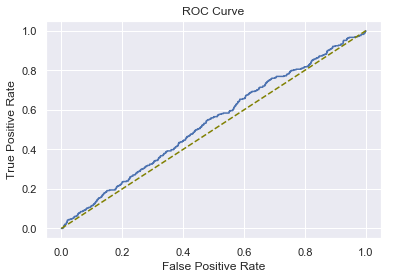

Naive Bayes Classifier
confusion matrix =  [[11994    35]
 [ 1320    52]]
tp =  52 fp =  35 fn =  1320 tn =  11994
accuracy score  =  0.8988881426759197
precision =  0.5977011494252874
recall =  0.037900874635568516
F1-score =  0.0712816997943797
auc =  0.5375948539814012
Cost for less false negative =  131983
Cost for less false positive =  4768


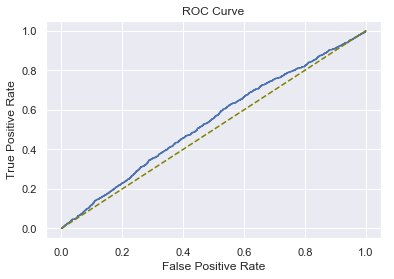

KeyboardInterrupt: 

In [41]:
# Doing 5 fold cross validation
from sklearn.model_selection import KFold
kf = KFold(n_splits = 5)
kf.get_n_splits(train_set)

for train_index, test_index in kf.split(train_set):
    train1, test1 = train_set[train_index], train_set[test_index]
    y_train = train1[:,-1]
    y_test = test1[:,-1]
    conti_train,dis_train = prepareData(train1)
    summaries_train = summarizeByClass(conti_train)
    prob1 = calculateProbDiscrete(dis_train)
    predictions,y_score = getPredictions(summaries_train, conti_train, prob1)
    getResult(y_train,predictions,y_score)
    conti_train,dis_train = prepareData(test1)
    summaries_train = summarizeByClass(conti_train)
    prob1 = calculateProbDiscrete(dis_train)
    predictions,y_score = getPredictions(summaries_train, conti_train, prob1)
    getResult(y_test,predictions,y_score)

In [ ]:
kf.get_n_splits(train_set_B)

for train_index, test_index in kf.split(train_set_B):
    train1, test1 = train_set_B[train_index], train_set_B[test_index]
    y_train = train1[:,-1]
    y_test = test1[:,-1]
    conti_train,dis_train = prepareData(train1)
    summaries_train = summarizeByClass(conti_train)
    prob1 = calculateProbDiscrete(dis_train)
    predictions,y_score = getPredictions(summaries_train, conti_train, prob1)
    getResult(y_train,predictions,y_score)
    conti_train,dis_train = prepareData(test1)
    summaries_train = summarizeByClass(conti_train)
    prob1 = calculateProbDiscrete(dis_train)
    predictions,y_score = getPredictions(summaries_train, conti_train, prob1)
    getResult(y_test,predictions,y_score)

Task 2.2 Running the classifier on training data

Naive Bayes Classifier
confusion matrix =  [[15043    38]
 [ 1614    57]]
tp =  57 fp =  38 fn =  1614 tn =  15043
accuracy score  =  0.9013849092645654
precision =  0.6
recall =  0.03411131059245961
F1-score =  0.06455266138165346
auc =  0.545554762312636
Cost for less false negative =  161381
Cost for less false positive =  5357


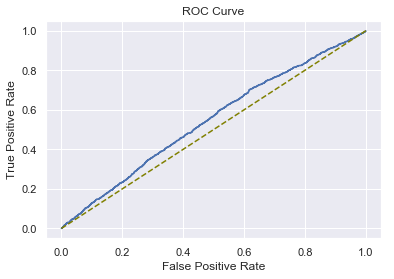

In [37]:
# Running classifier on train data A
conti_train,dis_train = prepareData(train_set)
summaries = summarizeByClass(conti_train)
prob1 = calculateProbDiscrete(dis_train)
predictions,y_score = getPredictions(summaries, conti_train, prob1)
getResult(Y_train,predictions,y_score)

Task 2.3 Running it on test data

Naive Bayes Classifier
confusion matrix =  [[3758    7]
 [ 411   12]]
tp =  12 fp =  7 fn =  411 tn =  3758
accuracy score  =  0.9001910219675263
precision =  0.631578947368421
recall =  0.028368794326241134
F1-score =  0.05429864253393665
auc =  0.5670051080155344
Cost for less false negative =  41095
Cost for less false positive =  1099


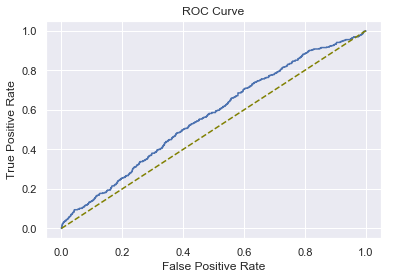

In [38]:
# Running classifier on test data A
conti_test,dis_test = prepareData(test_set)
summaries = summarizeByClass(conti_test)
prob1 = calculateProbDiscrete(dis_test)
predictions,y_score = getPredictions(summaries, conti_test, prob1)
getResult(Y_test,predictions,y_score)

Naive Bayes Classifier
confusion matrix =  [[19092     0]
 [ 2136     4]]
tp =  4 fp =  0 fn =  2136 tn =  19092
accuracy score  =  0.89939713639789
precision =  1.0
recall =  0.001869158878504673
F1-score =  0.0037313432835820895
auc =  0.49794502174419586
Cost for less false negative =  213596
Cost for less false positive =  2132


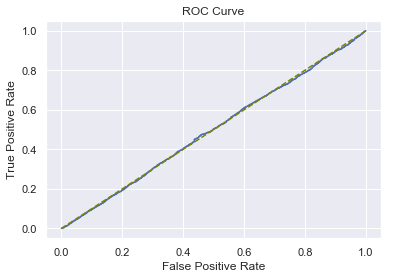

In [39]:
# Running classifier on train data B
conti_trainB,dis_trainB = prepareData(train_set_B)
summaries_B = summarizeByClass(conti_trainB)
prob1 = calculateProbDiscrete(dis_trainB)
predictions_B,y_score = getPredictions(summaries_B, conti_trainB, prob1)
getResult(Y_train_B,predictions_B,y_score)

Naive Bayes Classifier
confusion matrix =  [[4794    0]
 [ 511    3]]
tp =  3 fp =  0 fn =  511 tn =  4794
accuracy score  =  0.9037302185380558
precision =  1.0
recall =  0.005836575875486381
F1-score =  0.01160541586073501
auc =  0.4910452673494268
Cost for less false negative =  51097
Cost for less false positive =  508


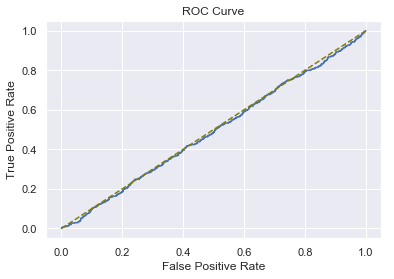

In [40]:
# Running classifier on test data B
conti_testB,dis_testB = prepareData(test_set_B)
summaries_B = summarizeByClass(conti_testB)
prob1 = calculateProbDiscrete(dis_testB)
predictions_B,y_score = getPredictions(summaries_B, conti_testB, prob1)
getResult(Y_test_B,predictions_B,y_score)

Task 2.4 The classifier is behaving the same for both training and test data so that sjhows that there is no overfitting or underfitting